In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("jokes_clean.csv")
df = df.dropna()

In [3]:
df.sample(10)

,id,text,length,num_comments,nsfw,score,timestamp,year
202436,6cgewp,reading book antigravity right impossible put,77,7,False,68,1495371793,2017
119599,4pcq9p,cut dead tree half looking saw eyes,78,67,False,1625,1466625949,2016
432479,ds5d63,white supremacists favorite dessert cake cake ...,66,3,False,2,1572987128,2019
310836,9ceair,sex like chess game 1 practice better play 2 n...,154,18,True,79,1535912726,2018
343551,adx5mb,doctor doctor keep thinking broken window doc ...,107,0,False,1,1546971417,2019
86931,3sz06g,terminators muslim name al bi baq,46,0,False,14,1447641312,2015
39279,2jrb8m,crowbar sears little guy sitting bar drinking ...,854,4,False,5,1413780921,2014
308341,99njzf,little johnny neighbour baby born without ears...,405,25,False,454,1535032316,2018
46518,2risnb,walrus go tupperware store wanted tight seal,78,1,False,4,1420559023,2015
254944,7qkxl3,bear chasing rabbit fairy interrupts magic fai...,658,0,False,7,1516035180,2018


# Exploratory Data Analysis
![Number of subscribers of r/Jokes](images/subscribers.png 'Number of subscribers of r/Jokes')

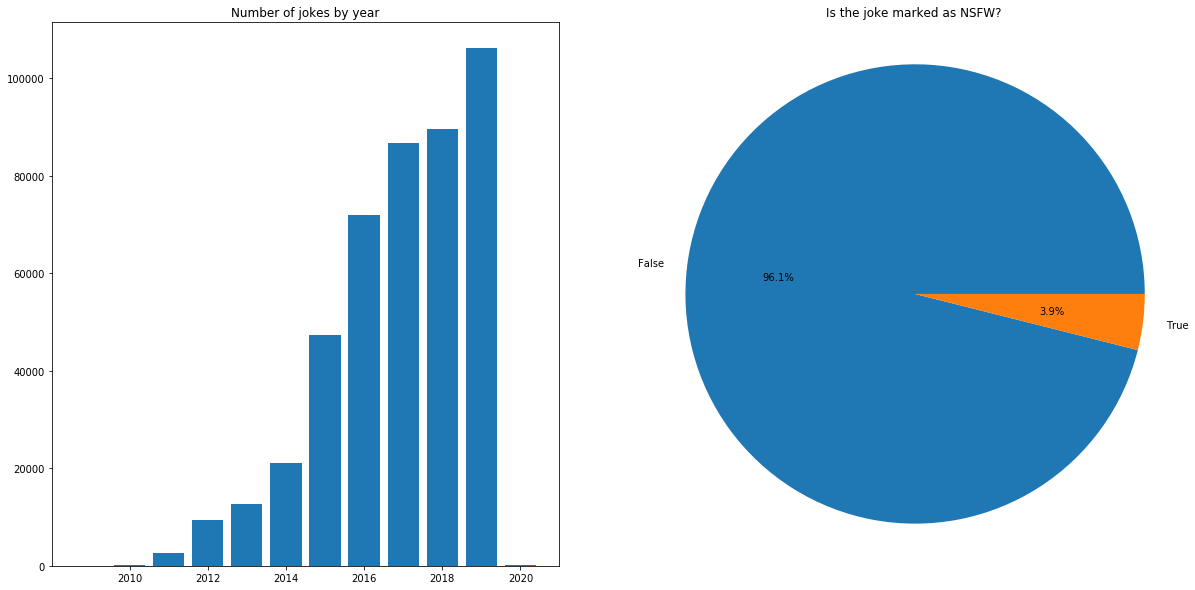

In [223]:
fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

labels = df['year'].value_counts().index
values = df['year'].value_counts().values
ax1.bar(labels, values)
ax1.set_title('Number of jokes by year')

labels = df['nsfw'].value_counts().index
values = df['nsfw'].value_counts().values
ax2.pie(values, labels=labels, autopct='%1.1f%%', startangle=0)
ax2.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax2.set_title('Is the joke marked as NSFW?')

plt.savefig('images/broad.png', bbox_inches='tight')
plt.show()

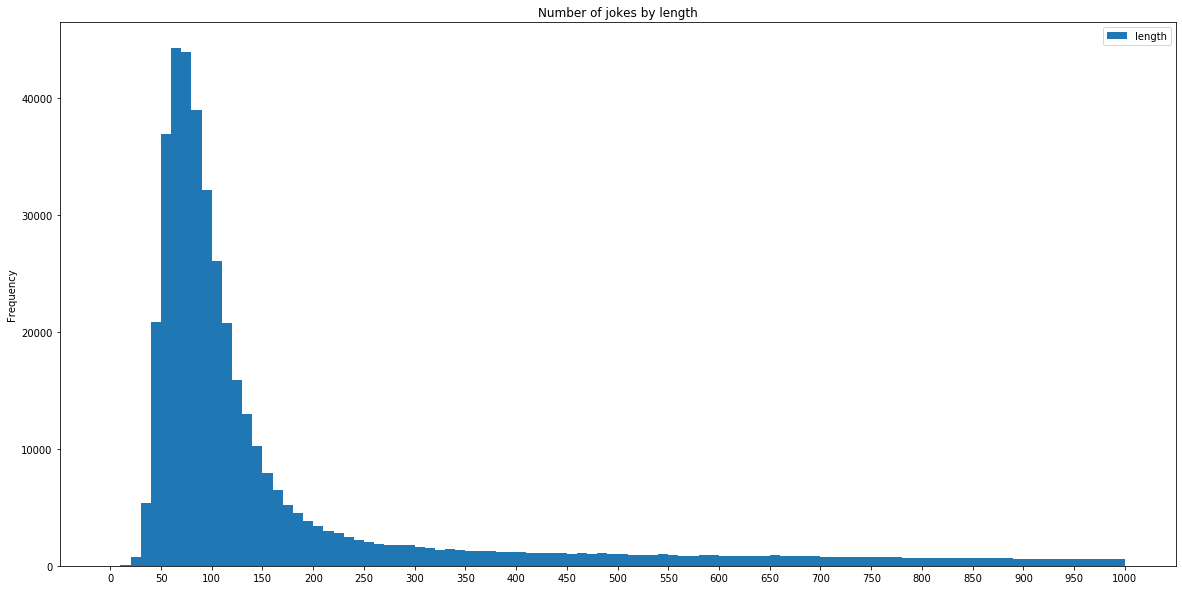

In [224]:
df[['length']].plot(kind='hist', bins=range(0, 1001, 10), xticks=range(0, 1001, 50), figsize=(20, 10), title='Number of jokes by length')
plt.savefig('images/jokes_by_length.png', bbox_inches='tight')

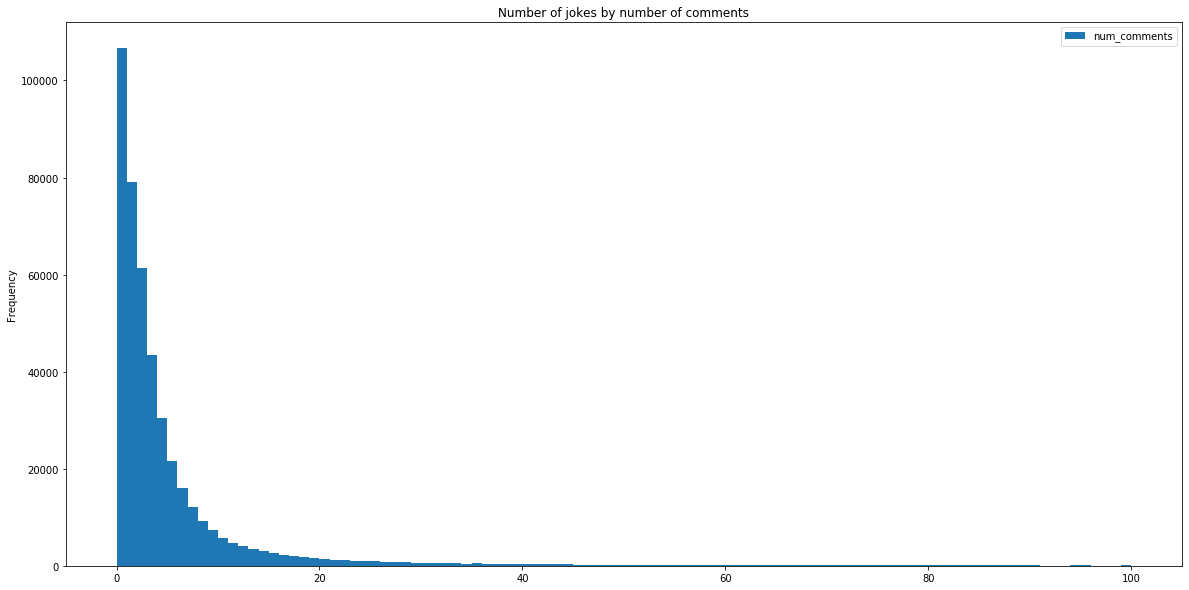

In [225]:
df[['num_comments']].plot(kind='hist', bins=range(0, 101, 1), figsize=(20, 10), title='Number of jokes by number of comments')
plt.savefig('images/jokes_by_num_comments.png', bbox_inches='tight')

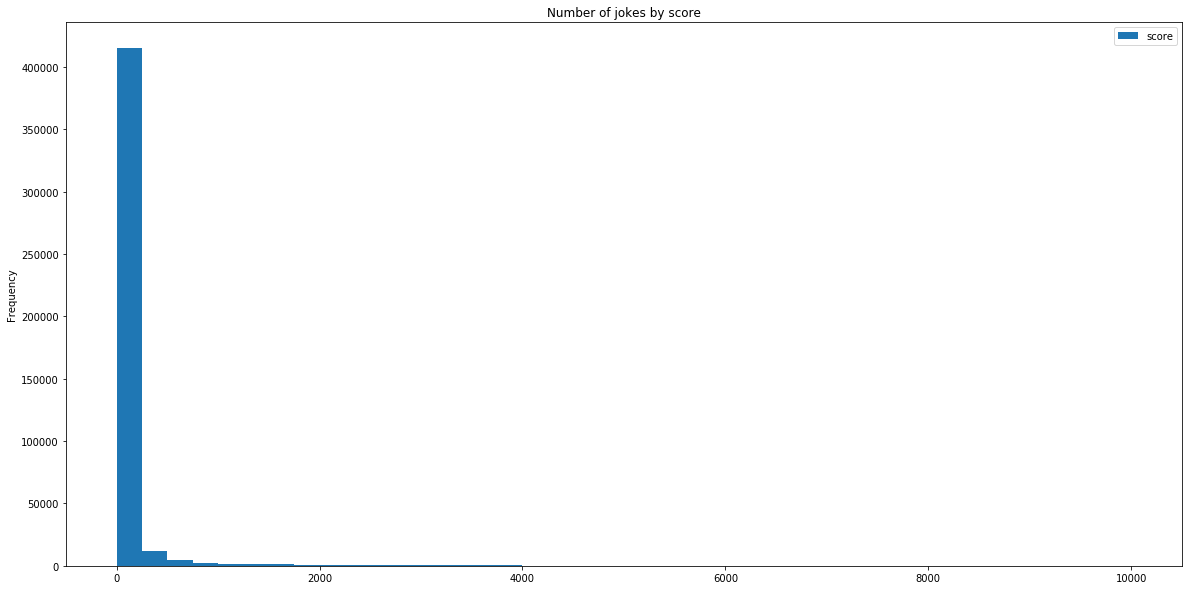

In [226]:
df[['score']].plot(kind='hist', bins=range(0, 10001, 250), figsize=(20, 10), title='Number of jokes by score')

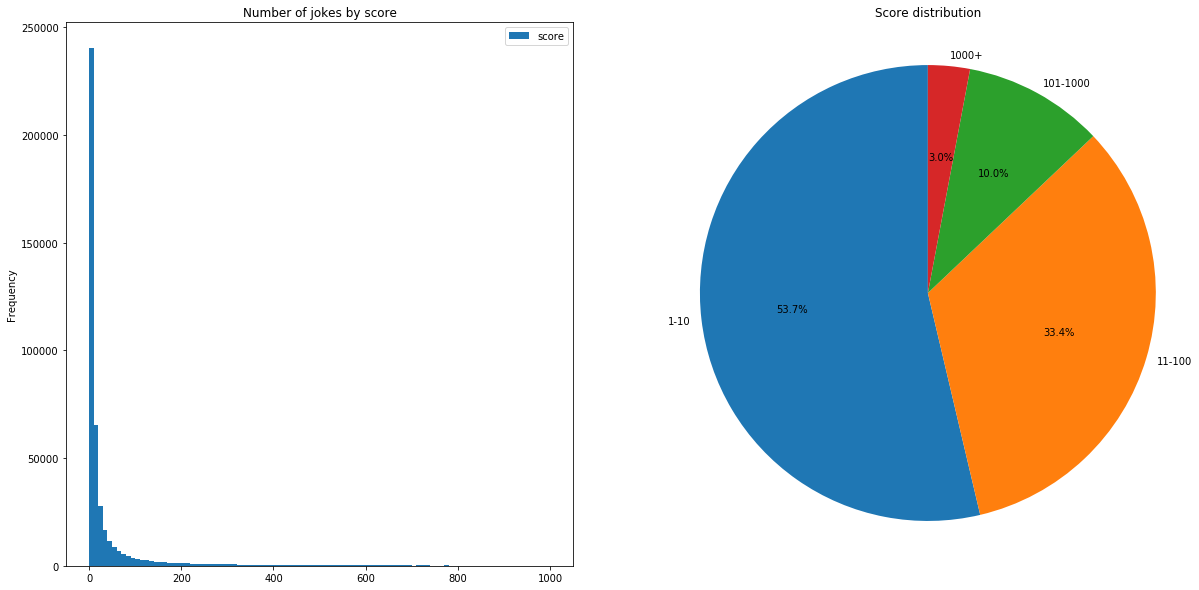

In [227]:
fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

df[['score']].plot(kind='hist', bins=range(0, 1001, 10), ax=ax1, title='Number of jokes by score')

def map_scores_to_categories(x):
    x = int(x)
    if x < 10:
        return 0
    elif x < 100:
        return 1
    elif x < 1000:
        return 2
    else:
        return 3

piedf = df.copy()
piedf['score'] = piedf['score'].apply(map_scores_to_categories)


labels = pd.Index(['1-10', '11-100', '101-1000', '1000+'])
# labels = piedf['score'].value_counts().index
values = piedf['score'].value_counts().values
ax2.pie(values, labels=labels, autopct='%1.1f%%', startangle=90, labeldistance=1.05)
ax2.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax2.set_title('Score distribution')

plt.savefig('images/score_pie.png', bbox_inches='tight')
plt.show()

### Still the same situation. Magnify!

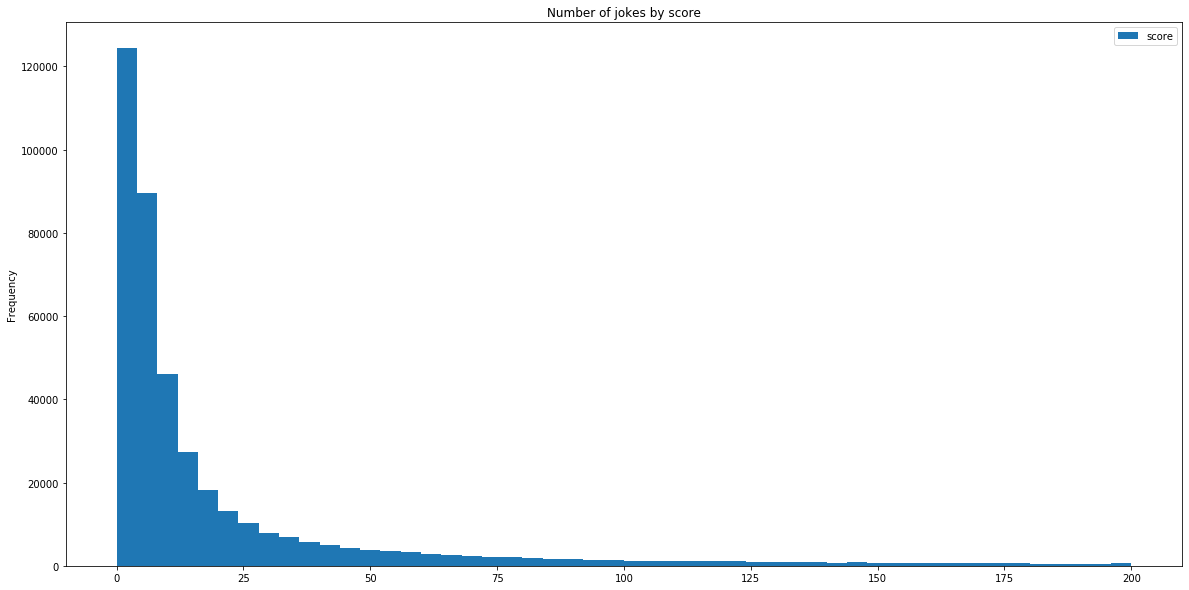

In [228]:
df[['score']].plot(kind='hist', bins=range(0, 201, 4), figsize=(20, 10), title='Number of jokes by score')
plt.savefig('images/jokes_by_score.png', bbox_inches='tight')

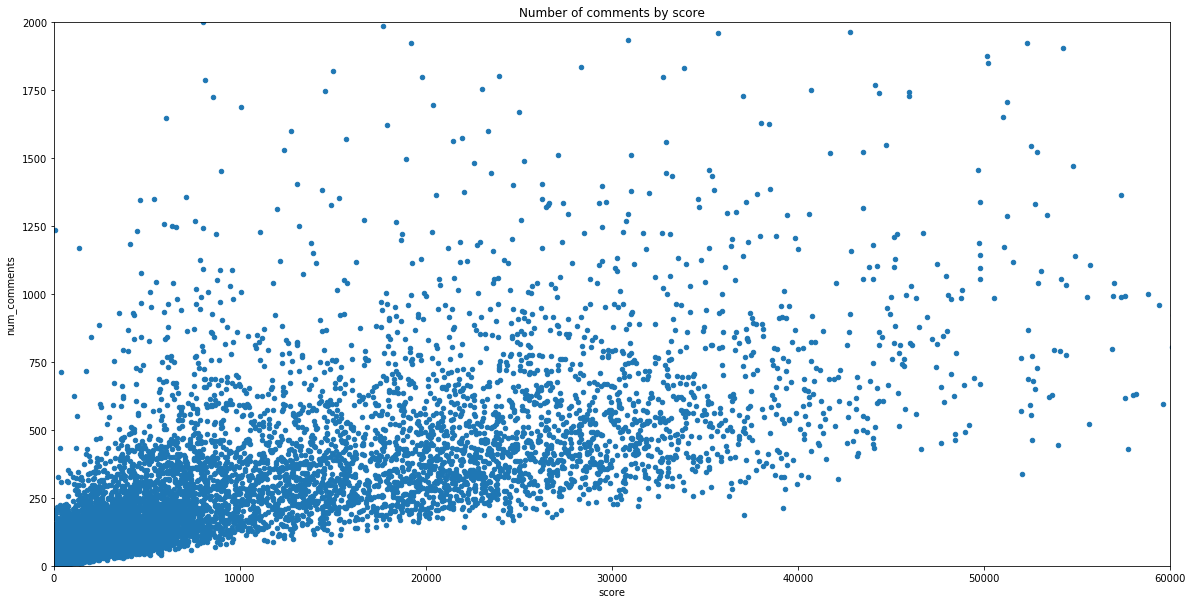

In [229]:
df.plot(kind='scatter',x='score',y='num_comments', figsize=(20, 10), xlim=(0, 60000), ylim=(0, 2000), title='Number of comments by score')
plt.savefig('images/comments_by_score.png', bbox_inches='tight')

### We see the trend - bigger score means more comments, but not necessarily the other way around.

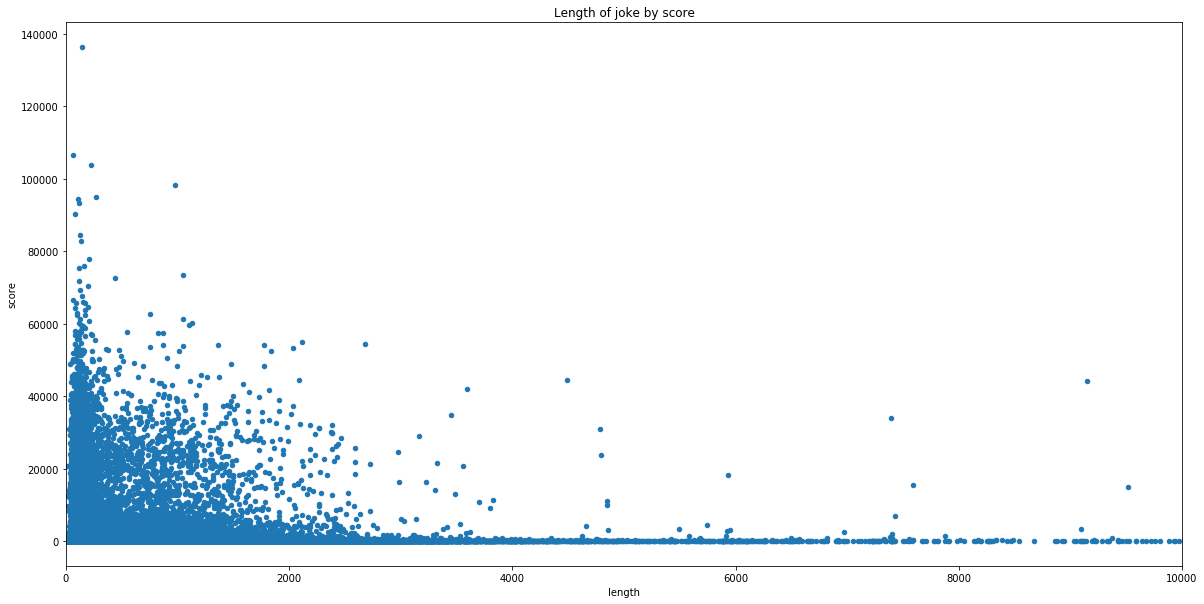

In [230]:
df.plot(kind='scatter',x='length',y='score', xlim=(0, 10000), figsize=(20, 10), title='Length of joke by score')
plt.savefig('images/length_by_score.png', bbox_inches='tight')

### We also a tendency of really long jokes to be worse than shorter ones.

In [231]:
y_nsfwdf = df.loc[df['nsfw'].astype(str) == 'True']
avg_y_score = sum(y_nsfwdf['score'].values)/len(y_nsfwdf.index)
n_nsfwdf = df.loc[df['nsfw'].astype(str) == 'False']
avg_n_score = sum(n_nsfwdf['score'].values)/len(n_nsfwdf.index)
print(f'Avg. NSFW score: {avg_y_score}')
print(f'Avg. non-NSFW score: {avg_n_score}')

Avg. NSFW score: 799.7765648985161
Avg. non-NSFW score: 257.11575871415886


### And finally, dirty jokes seem to do a lot better on average.

# Classifier

In [245]:
from sklearn.feature_extraction.text import TfidfVectorizer

cldf = df.sample(25000)

# This vectorizer breaks text into single words and bi-grams
# and then calculates the TF-IDF representation
vectorizer = TfidfVectorizer(ngram_range=(1,2))

# the 'fit' builds up the vocabulary from all the jokes
# while the 'transform' step turns each indivdual text into
# a matrix of numbers.
vectors = vectorizer.fit_transform(cldf['text'].values)
score_vectorizer = vectorizer

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(vectors, cldf['score'].values, test_size=0.25, random_state=42)


In [236]:
from sklearn.svm import LinearSVC
# initialise the SVM classifier
classifier = LinearSVC()

# train the classifier
classifier.fit(X_train, y_train)

score_predictor = classifier

In [237]:
from sklearn.metrics import accuracy_score
preds = classifier.predict(X_test)
print(accuracy_score(y_test, preds))
for pred, act in zip(preds[:20], y_test[:20]):
    print(f'Predicted: {pred}\tActual: {act}')
   
count = 0
for pred, act in zip(preds, y_test):
    if abs(pred - act) <= 10:
        count += 1

print(f'Personal metric: {count/len(preds)}')

0.08288
Predicted: 1	Actual: 8
Predicted: 2	Actual: 1
Predicted: 3	Actual: 104
Predicted: 1833	Actual: 4
Predicted: 2	Actual: 13
Predicted: 254	Actual: 24
Predicted: 4	Actual: 20
Predicted: 1	Actual: 2
Predicted: 1	Actual: 11
Predicted: 16	Actual: 12
Predicted: 3	Actual: 2
Predicted: 4	Actual: 2
Predicted: 1	Actual: 150
Predicted: 4	Actual: 4
Predicted: 37	Actual: 1
Predicted: 1	Actual: 7
Predicted: 1	Actual: 84
Predicted: 744	Actual: 43
Predicted: 5	Actual: 9
Predicted: 196	Actual: 604
Personal metric: 0.57136


### Now that's what I call accuracy!

(If we look at the personal metric, then the score is not too shabby - a difference of ten between predicted and actual isn't that bad, taking into account the score distribution)

Obviously, this strategy is bad. Let's switch things up a bit by using a different 'score' to grade our jokes.

## Group into 3 categories

In [152]:
def map_value(x):
    x = int(x)
    if x < 5:
        x = 0
    elif x < 100:
        x = 1
    else:
        x = 2
    return x
        
df['mark'] = df['score'].apply(map_value)

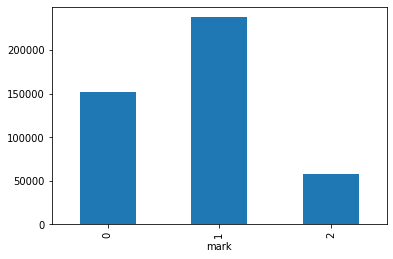

In [153]:
df.groupby('mark')['id'].nunique().plot(kind='bar')

Group by score: 0 - Average joke, 1 - Better joke, 2 - Good joke

Now extract the same amount from each category: since we know that good jokes have the smallest number, we can first extract them, then get a sample from the other categories

In [154]:
cldf = df[df['mark'] == 2]
category_size = cldf.shape[0]

cldf = pd.concat([cldf, df[df['mark'] == 0].sample(category_size), df[df['mark'] == 1].sample(category_size)])

In [155]:
from sklearn.feature_extraction.text import TfidfVectorizer

# This vectorizer breaks text into single words and bi-grams
# and then calculates the TF-IDF representation
tf_vectorizer = TfidfVectorizer(ngram_range=(1,2))

from sklearn.feature_extraction.text import CountVectorizer
# Fit the CountVectorizer to the training data
c_vectorizer = CountVectorizer()

In [156]:
# the 'fit' builds up the vocabulary from all the jokes
# while the 'transform' step turns each indivdual text into
# a matrix of numbers.
vectors = tf_vectorizer.fit_transform(cldf['text'].values)
#vectors = c_vectorizer.fit_transform(cldf['text'].values)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(vectors, cldf['mark'].values, test_size=0.25, random_state=42)

### LinearSVC

In [157]:
from sklearn.svm import LinearSVC
# initialise the SVM classifier
classifier = LinearSVC(max_iter=1500)

# train the classifier
classifier.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1500,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [158]:
from sklearn.metrics import accuracy_score
preds = classifier.predict(X_test)
print(accuracy_score(y_test, preds))
for pred, act in zip(preds[:20], y_test[:20]):
    print(f'Predicted: {pred}\tActual: {act}')

0.48175031107424304
Predicted: 2	Actual: 0
Predicted: 1	Actual: 1
Predicted: 0	Actual: 1
Predicted: 1	Actual: 1
Predicted: 1	Actual: 2
Predicted: 2	Actual: 2
Predicted: 2	Actual: 2
Predicted: 2	Actual: 1
Predicted: 1	Actual: 0
Predicted: 0	Actual: 1
Predicted: 0	Actual: 0
Predicted: 1	Actual: 1
Predicted: 0	Actual: 0
Predicted: 1	Actual: 0
Predicted: 1	Actual: 1
Predicted: 0	Actual: 1
Predicted: 1	Actual: 0
Predicted: 0	Actual: 2
Predicted: 1	Actual: 0
Predicted: 2	Actual: 1


#### Count vectorizer performing worse (\~0.437) than TF-IDF vectorizer (\~0.479) - expected

### Logistic Regression

In [159]:
from sklearn.linear_model import LogisticRegression,SGDClassifier
model = LogisticRegression(max_iter=500)
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [160]:
from sklearn.metrics import accuracy_score
predictions = model.predict(X_test)

print(accuracy_score(y_test, predictions))
for pred, act in zip(predictions[:20], y_test[:20]):
    print(f'Predicted: {pred}\tActual: {act}')

0.48820222130052077
Predicted: 2	Actual: 0
Predicted: 1	Actual: 1
Predicted: 0	Actual: 1
Predicted: 1	Actual: 1
Predicted: 1	Actual: 2
Predicted: 2	Actual: 2
Predicted: 2	Actual: 2
Predicted: 2	Actual: 1
Predicted: 1	Actual: 0
Predicted: 0	Actual: 1
Predicted: 0	Actual: 0
Predicted: 0	Actual: 1
Predicted: 0	Actual: 0
Predicted: 1	Actual: 0
Predicted: 1	Actual: 1
Predicted: 0	Actual: 1
Predicted: 1	Actual: 0
Predicted: 0	Actual: 2
Predicted: 1	Actual: 0
Predicted: 2	Actual: 1


### Post-analysis

#### Somewhat better accuracy using Logistic Regression (~0.486)

In [161]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.49      0.57      0.53     14444
           1       0.39      0.29      0.33     14556
           2       0.56      0.60      0.58     14398

    accuracy                           0.49     43398
   macro avg       0.48      0.49      0.48     43398
weighted avg       0.48      0.49      0.48     43398



#### Looking at the f1-scores, we can see that great jokes are the easiest to predict (still... only ~0.57)
#### Let's also look at the confusion matrix

In [162]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, predictions))

[[8269 3751 2424]
 [5868 4291 4397]
 [2669 3102 8627]]


#### In general, the confusion matrix helps us a lot. Here, we can see that average(0) jokes are mostly confused with good(1) jokes, good jokes are all over the place, and great(2) jokes are mostly confused with the others pretty evenly, actually.

## Let's give it one more try - this time, only with two categories: good jokes(1) and bad jokes(0).

In [163]:
def map_value(x):
    x = int(x)
    if x < 5:
        x = 0
    elif x > 100:
        x = 1
    else:
        x = -1
    return x
        
df['mark'] = df['score'].apply(map_value)

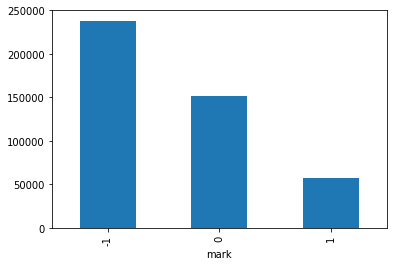

In [164]:
df.groupby('mark')['id'].nunique().plot(kind='bar')

#### -1 to jokes between 5 and 100, thos are going to be ignored - then we follow the same procedure

In [165]:
cldf = df[df['mark'] == 1]
category_size = cldf.shape[0]

cldf = pd.concat([cldf, df[df['mark'] == 0].sample(category_size)])

In [166]:
from sklearn.feature_extraction.text import TfidfVectorizer

# This vectorizer breaks text into single words and bi-grams
# and then calculates the TF-IDF representation
tf_vectorizer = TfidfVectorizer(ngram_range=(1,2))

from sklearn.feature_extraction.text import CountVectorizer
# Fit the CountVectorizer to the training data
c_vectorizer = CountVectorizer()

In [167]:
# the 'fit' builds up the vocabulary from all the jokes
# while the 'transform' step turns each indivdual text into
# a matrix of numbers.
vectors = tf_vectorizer.fit_transform(cldf['text'].values)
#vectors = c_vectorizer.fit_transform(cldf['text'].values)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(vectors, cldf['mark'].values, test_size=0.25, random_state=42)

In [168]:
from sklearn.naive_bayes import BernoulliNB
bernoulli = BernoulliNB()
bernoulli.fit(X_train, y_train)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [169]:
from sklearn.metrics import accuracy_score
predictions = bernoulli.predict(X_test)

print(accuracy_score(y_test, predictions))
for pred, act in zip(predictions[:20], y_test[:20]):
    print(f'Predicted: {pred}\tActual: {act}')

0.6180232154027941
Predicted: 0	Actual: 0
Predicted: 0	Actual: 0
Predicted: 0	Actual: 0
Predicted: 1	Actual: 0
Predicted: 0	Actual: 0
Predicted: 1	Actual: 1
Predicted: 1	Actual: 0
Predicted: 1	Actual: 1
Predicted: 0	Actual: 0
Predicted: 1	Actual: 1
Predicted: 0	Actual: 1
Predicted: 1	Actual: 1
Predicted: 0	Actual: 1
Predicted: 0	Actual: 1
Predicted: 0	Actual: 1
Predicted: 1	Actual: 1
Predicted: 1	Actual: 1
Predicted: 0	Actual: 1
Predicted: 1	Actual: 1
Predicted: 1	Actual: 0


### LinearSVC

In [170]:
from sklearn.svm import LinearSVC
# initialise the SVM classifier
classifier = LinearSVC(max_iter=1500)

# train the classifier
classifier.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1500,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [171]:
from sklearn.metrics import accuracy_score
preds = classifier.predict(X_test)
print(accuracy_score(y_test, preds))
for pred, act in zip(preds[:20], y_test[:20]):
    print(f'Predicted: {pred}\tActual: {act}')

0.7412247167581845
Predicted: 0	Actual: 0
Predicted: 0	Actual: 0
Predicted: 1	Actual: 0
Predicted: 1	Actual: 0
Predicted: 0	Actual: 0
Predicted: 1	Actual: 1
Predicted: 1	Actual: 0
Predicted: 1	Actual: 1
Predicted: 0	Actual: 0
Predicted: 1	Actual: 1
Predicted: 0	Actual: 1
Predicted: 1	Actual: 1
Predicted: 1	Actual: 1
Predicted: 1	Actual: 1
Predicted: 1	Actual: 1
Predicted: 1	Actual: 1
Predicted: 1	Actual: 1
Predicted: 1	Actual: 1
Predicted: 1	Actual: 1
Predicted: 1	Actual: 0


### Logistic Regression

In [172]:
from sklearn.linear_model import LogisticRegression,SGDClassifier
model = LogisticRegression(max_iter=500)
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [173]:
from sklearn.metrics import accuracy_score
predictions = model.predict(X_test)

print(accuracy_score(y_test, predictions))
for pred, act in zip(predictions[:20], y_test[:20]):
    print(f'Predicted: {pred}\tActual: {act}')

0.7279835963022173
Predicted: 0	Actual: 0
Predicted: 0	Actual: 0
Predicted: 0	Actual: 0
Predicted: 1	Actual: 0
Predicted: 0	Actual: 0
Predicted: 1	Actual: 1
Predicted: 1	Actual: 0
Predicted: 1	Actual: 1
Predicted: 0	Actual: 0
Predicted: 1	Actual: 1
Predicted: 0	Actual: 1
Predicted: 1	Actual: 1
Predicted: 0	Actual: 1
Predicted: 1	Actual: 1
Predicted: 1	Actual: 1
Predicted: 1	Actual: 1
Predicted: 1	Actual: 1
Predicted: 1	Actual: 1
Predicted: 1	Actual: 1
Predicted: 1	Actual: 0


### Post-analysis

#### This time, SVM (\~0.740) performing a bit better than LogisticRegression (\~0.730)

For the sake of it, we also tried the Bernoulli Naive-Bayes, but it performed significantly worse (~0.617).

In [174]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.71      0.76      0.74     14288
           1       0.75      0.70      0.72     14486

    accuracy                           0.73     28774
   macro avg       0.73      0.73      0.73     28774
weighted avg       0.73      0.73      0.73     28774



In [175]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, predictions))

[[10879  3409]
 [ 4418 10068]]


#### Good jokes being confused with bad jokes more than the other way around.

## More features?

Let's also involve the joke length, and whether it is NSFW or not.

In [176]:
def map_score_to_mark(x):
    x = int(x)
    if x < 5:
        x = 0
    elif x > 100:
        x = 1
    else:
        x = -1
    return x
        
def bool_to_bit(x):
    x = bool(x)
    if x:
        return 1
    else:
        return 0

def map_length(x):
    x = int(x)
    if x < 50:
        x = 0
    elif x < 100:
        x = 1
    elif x < 150:
        x = 2
    else:
        x = 3
    return x
    
df['mark'] = df['score'].apply(map_score_to_mark)
df['nsfw'] = df['nsfw'].apply(bool_to_bit)
df['length'] = df['length'].apply(map_length)

df.sample(10)

,id,text,length,num_comments,nsfw,score,timestamp,year,mark
73258,3g5x3k,thor start calling ironman learned suit made g...,3,4,0,14,1438975817,2015,-1
94761,40ns7e,know justin bieber canadian canadian could get...,2,7,0,216,1452624725,2016,1
229068,702m3c,met inventor bobble head name robert bullhead ...,1,0,0,8,1505399750,2017,-1
347365,aic94l,know breathe smiling kidding wanted make smile,1,29,0,192,1548091117,2019,1
336912,a6kdp7,organised secret santa work put name 10 pieces...,2,7,0,80,1544919173,2018,-1
290868,8qpxhy,dress make butt look big asked contrary replie...,2,0,0,6,1528867687,2018,-1
202875,6crpfh,knockknock nineeleven nineeleven said never fo...,1,3,0,66,1495504365,2017,-1
218613,6qsuos,call possessed lens demonocle,0,0,0,7,1501549200,2017,-1
274777,8axk44,difference politician flying pig letter f,1,106,0,2493,1523271654,2018,1
308161,99ghmt,camel leg thief shaun tourist visiting small t...,3,1,0,7,1534967181,2018,-1


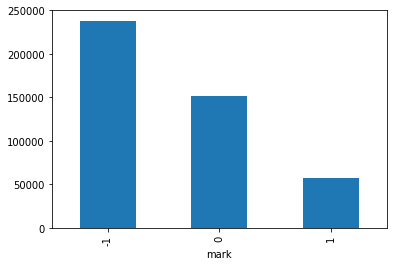

In [177]:
df.groupby('mark')['id'].nunique().plot(kind='bar')

In [178]:
cldf = df[df['mark'] == 1]
category_size = cldf.shape[0]

cldf = pd.concat([cldf, df[df['mark'] == 0].sample(category_size)])

In [179]:
from sklearn.feature_extraction.text import TfidfVectorizer

# This vectorizer breaks text into single words and bi-grams
# and then calculates the TF-IDF representation
tf_vectorizer = TfidfVectorizer(ngram_range=(1,2))

# the 'fit' builds up the vocabulary from all the jokes
# while the 'transform' step turns each indivdual text into
# a matrix of numbers.
vectors = tf_vectorizer.fit_transform(cldf['text'].values)
#vectors = c_vectorizer.fit_transform(cldf['text'].values)

In [180]:
from sklearn.model_selection import train_test_split
X_text_train, X_text_test, y_train, y_test = train_test_split(vectors, cldf['mark'].values, test_size=0.2, random_state=42)
X_nsfw_train, X_nsfw_test, y_train, y_test = train_test_split(cldf['nsfw'].values, cldf['mark'].values, test_size=0.2, random_state=42)
X_length_train, X_length_test, y_train, y_test = train_test_split(cldf['length'].values, cldf['mark'].values, test_size=0.2, random_state=42)

from scipy.sparse import hstack
X_train = hstack((X_text_train, X_nsfw_train[:, None], X_length_train[:, None]))
X_test = hstack((X_text_test, X_nsfw_test[:, None], X_length_test[:, None]))

In [181]:
from sklearn.naive_bayes import BernoulliNB
bernoulli = BernoulliNB()
bernoulli.fit(X_train, y_train)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [182]:
from sklearn.metrics import accuracy_score
predictions = bernoulli.predict(X_test)

print(accuracy_score(y_test, predictions))
for pred, act in zip(predictions[:20], y_test[:20]):
    print(f'Predicted: {pred}\tActual: {act}')

0.6152743385898606
Predicted: 0	Actual: 0
Predicted: 0	Actual: 0
Predicted: 0	Actual: 0
Predicted: 0	Actual: 0
Predicted: 0	Actual: 0
Predicted: 1	Actual: 1
Predicted: 0	Actual: 0
Predicted: 1	Actual: 1
Predicted: 0	Actual: 0
Predicted: 1	Actual: 1
Predicted: 0	Actual: 1
Predicted: 1	Actual: 1
Predicted: 0	Actual: 1
Predicted: 0	Actual: 1
Predicted: 0	Actual: 1
Predicted: 1	Actual: 1
Predicted: 1	Actual: 1
Predicted: 0	Actual: 1
Predicted: 1	Actual: 1
Predicted: 0	Actual: 0


### LinearSVC

In [183]:
from sklearn.svm import LinearSVC
# initialise the SVM classifier
classifier = LinearSVC(max_iter=1500)

# train the classifier
classifier.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1500,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [184]:
from sklearn.metrics import accuracy_score
preds = classifier.predict(X_test)
print(accuracy_score(y_test, preds))
for pred, act in zip(preds[:20], y_test[:20]):
    print(f'Predicted: {pred}\tActual: {act}')

0.7423432816369087
Predicted: 1	Actual: 0
Predicted: 0	Actual: 0
Predicted: 0	Actual: 0
Predicted: 1	Actual: 0
Predicted: 0	Actual: 0
Predicted: 1	Actual: 1
Predicted: 1	Actual: 0
Predicted: 1	Actual: 1
Predicted: 1	Actual: 0
Predicted: 1	Actual: 1
Predicted: 0	Actual: 1
Predicted: 1	Actual: 1
Predicted: 1	Actual: 1
Predicted: 1	Actual: 1
Predicted: 1	Actual: 1
Predicted: 1	Actual: 1
Predicted: 1	Actual: 1
Predicted: 1	Actual: 1
Predicted: 1	Actual: 1
Predicted: 0	Actual: 0


### Logistic Regression

In [185]:
from sklearn.linear_model import LogisticRegression,SGDClassifier
model = LogisticRegression(max_iter=500)
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [186]:
from sklearn.metrics import accuracy_score
predictions = model.predict(X_test)

print(accuracy_score(y_test, predictions))
for pred, act in zip(predictions[:20], y_test[:20]):
    print(f'Predicted: {pred}\tActual: {act}')

0.7284851644293844
Predicted: 1	Actual: 0
Predicted: 0	Actual: 0
Predicted: 0	Actual: 0
Predicted: 1	Actual: 0
Predicted: 0	Actual: 0
Predicted: 1	Actual: 1
Predicted: 1	Actual: 0
Predicted: 1	Actual: 1
Predicted: 1	Actual: 0
Predicted: 1	Actual: 1
Predicted: 0	Actual: 1
Predicted: 1	Actual: 1
Predicted: 1	Actual: 1
Predicted: 1	Actual: 1
Predicted: 1	Actual: 1
Predicted: 1	Actual: 1
Predicted: 1	Actual: 1
Predicted: 1	Actual: 1
Predicted: 1	Actual: 1
Predicted: 0	Actual: 0


In [187]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.71      0.76      0.73     11338
           1       0.75      0.70      0.72     11681

    accuracy                           0.73     23019
   macro avg       0.73      0.73      0.73     23019
weighted avg       0.73      0.73      0.73     23019



In [188]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, predictions))

[[8571 2767]
 [3483 8198]]


### No improvement...

## Joke evaluator

In [11]:
import re
import string
from nltk.corpus import stopwords

stop = stopwords.words('english')

qh_pattern = re.compile(r'-')
alnum_pattern = re.compile(r'[^A-Za-z0-9 ]+')

def clean_text(s):
    s = str(s).lower()
    # merge hyphens into the words
    s = qh_pattern.sub('', s)
    # replace with space instead of nothing
    # to cover cases like 'words word.word words'
    s = alnum_pattern.sub(' ', s)
    # remove stop words
    s = ' '.join([word for word in s.split() if word not in stop])
    # to lowercase
    # then remove spaces at the beginning and at the end
    return s.strip()


def is_this_good(joke_text, joke_nsfw):
    joke_text = clean_text(joke_text)
    joke_length = len(joke_text)
    joke_text = tf_vectorizer.transform([joke_text])
    jinput = hstack((joke_text, joke_nsfw, joke_length))
    
    pred = classifier.predict(jinput)
    
    if pred == 0:
        return 'Bad joke!'
    else:
        return 'Good joke!'

In [23]:
joke_text = """
God: *creates worm* Hey there little buddy!

Worm: Thanks for the “worm” welcome

God: creates birds
"""
is_this_good(joke_text, 0)

NameError: name 'tf_vectorizer' is not defined

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

cldf = df[df['score'] < 100]
print(len(cldf.index))

# This vectorizer breaks text into single words and bi-grams
# and then calculates the TF-IDF representation
vectorizer = TfidfVectorizer(ngram_range=(1,2))

# the 'fit' builds up the vocabulary from all the jokes
# while the 'transform' step turns each indivdual text into
# a matrix of numbers.
vectors = vectorizer.fit_transform(cldf['text'].values)
score_vectorizer = vectorizer

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(vectors, cldf['score'].values, test_size=0.25, random_state=42)


389888


In [5]:
from sklearn.svm import LinearSVC
# initialise the SVM classifier
classifier = LinearSVC()

# train the classifier
classifier.fit(X_train, y_train)

score_predictor = classifier

In [25]:
from sklearn.metrics import accuracy_score
preds = classifier.predict(X_test)
print(accuracy_score(y_test, preds))
for pred, act in zip(preds[:20], y_test[:20]):
    print(f'Predicted: {pred}\tActual: {act}')
   
count_10 = 0
for pred, act in zip(preds, y_test):
    if abs(pred - act) <= 10:
        count_10 += 1
print(f'Personal metric (10): {count_10/len(preds)}')        

0.09012844714379514
Predicted: 5	Actual: 9
Predicted: 2	Actual: 1
Predicted: 2	Actual: 1
Predicted: 1	Actual: 4
Predicted: 27	Actual: 2
Predicted: 2	Actual: 16
Predicted: 27	Actual: 15
Predicted: 2	Actual: 22
Predicted: 2	Actual: 71
Predicted: 16	Actual: 7
Predicted: 3	Actual: 2
Predicted: 3	Actual: 1
Predicted: 3	Actual: 18
Predicted: 1	Actual: 13
Predicted: 7	Actual: 7
Predicted: 1	Actual: 1
Predicted: 1	Actual: 10
Predicted: 1	Actual: 60
Predicted: 15	Actual: 13
Predicted: 4	Actual: 4
Personal metric (10): 0.6700385751805646


In [15]:
def get_score_of_joke(joke_text):
    clean_joke = clean_text(joke_text)
    jinput = score_vectorizer.transform([clean_joke])
    return score_predictor.predict(jinput)[0]

In [24]:
print(get_score_of_joke(joke_text))

[2]
